# $\verb|Multi-Variate Time Series Forecasting using Long Short Term Memory|$

*Predict the pollution at the next hour.*

For this task, we'll use $\verb|Air Pollution Dataset of American Embassy at Beijing|$

### *Basic Imports below*

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
import seaborn as sns                            # more plots
sns.set()
from tqdm import tqdm_notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## 1. Basic Data Preparation 

In [2]:
raw_data = pd.read_csv('./raw.csv')
raw_data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


### 1.1. Combining $\verb|year, month, day, hour|$ feature to a $\verb|Pandas Datetime|$ format.

In [3]:
date_parser = lambda x: pd.datetime.strptime(x,"%Y %m %d %H")
corr_ind = pd.read_csv("./raw.csv",parse_dates=[['year','month','day','hour']],date_parser = date_parser, index_col=0)
corr_ind.drop('No', axis = 1,inplace = True)
corr_ind.index.rename("date",inplace = True)
corr_ind.rename(columns = {'pm2.5':'pollution','DEWP':'dew','TEMP':'temp','PRES':'press','cbwd':'wnd_dir','Iws':'wnd_spd','Is':'snow','Ir':'rain'},inplace = True)

### 1.2. Removing first 24 hors of NaN from $\verb|pm2.5|$ feature.  

Removing out first 24 rows as there is no data for $\verb|pm2.5|$ available for the first day.

In [4]:
corr_ind = corr_ind.iloc[24:]

In [5]:
corr_ind.fillna(0, inplace = True)

In [6]:
corr_ind

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


### 1.3. Creating quick plots for each feature for reference

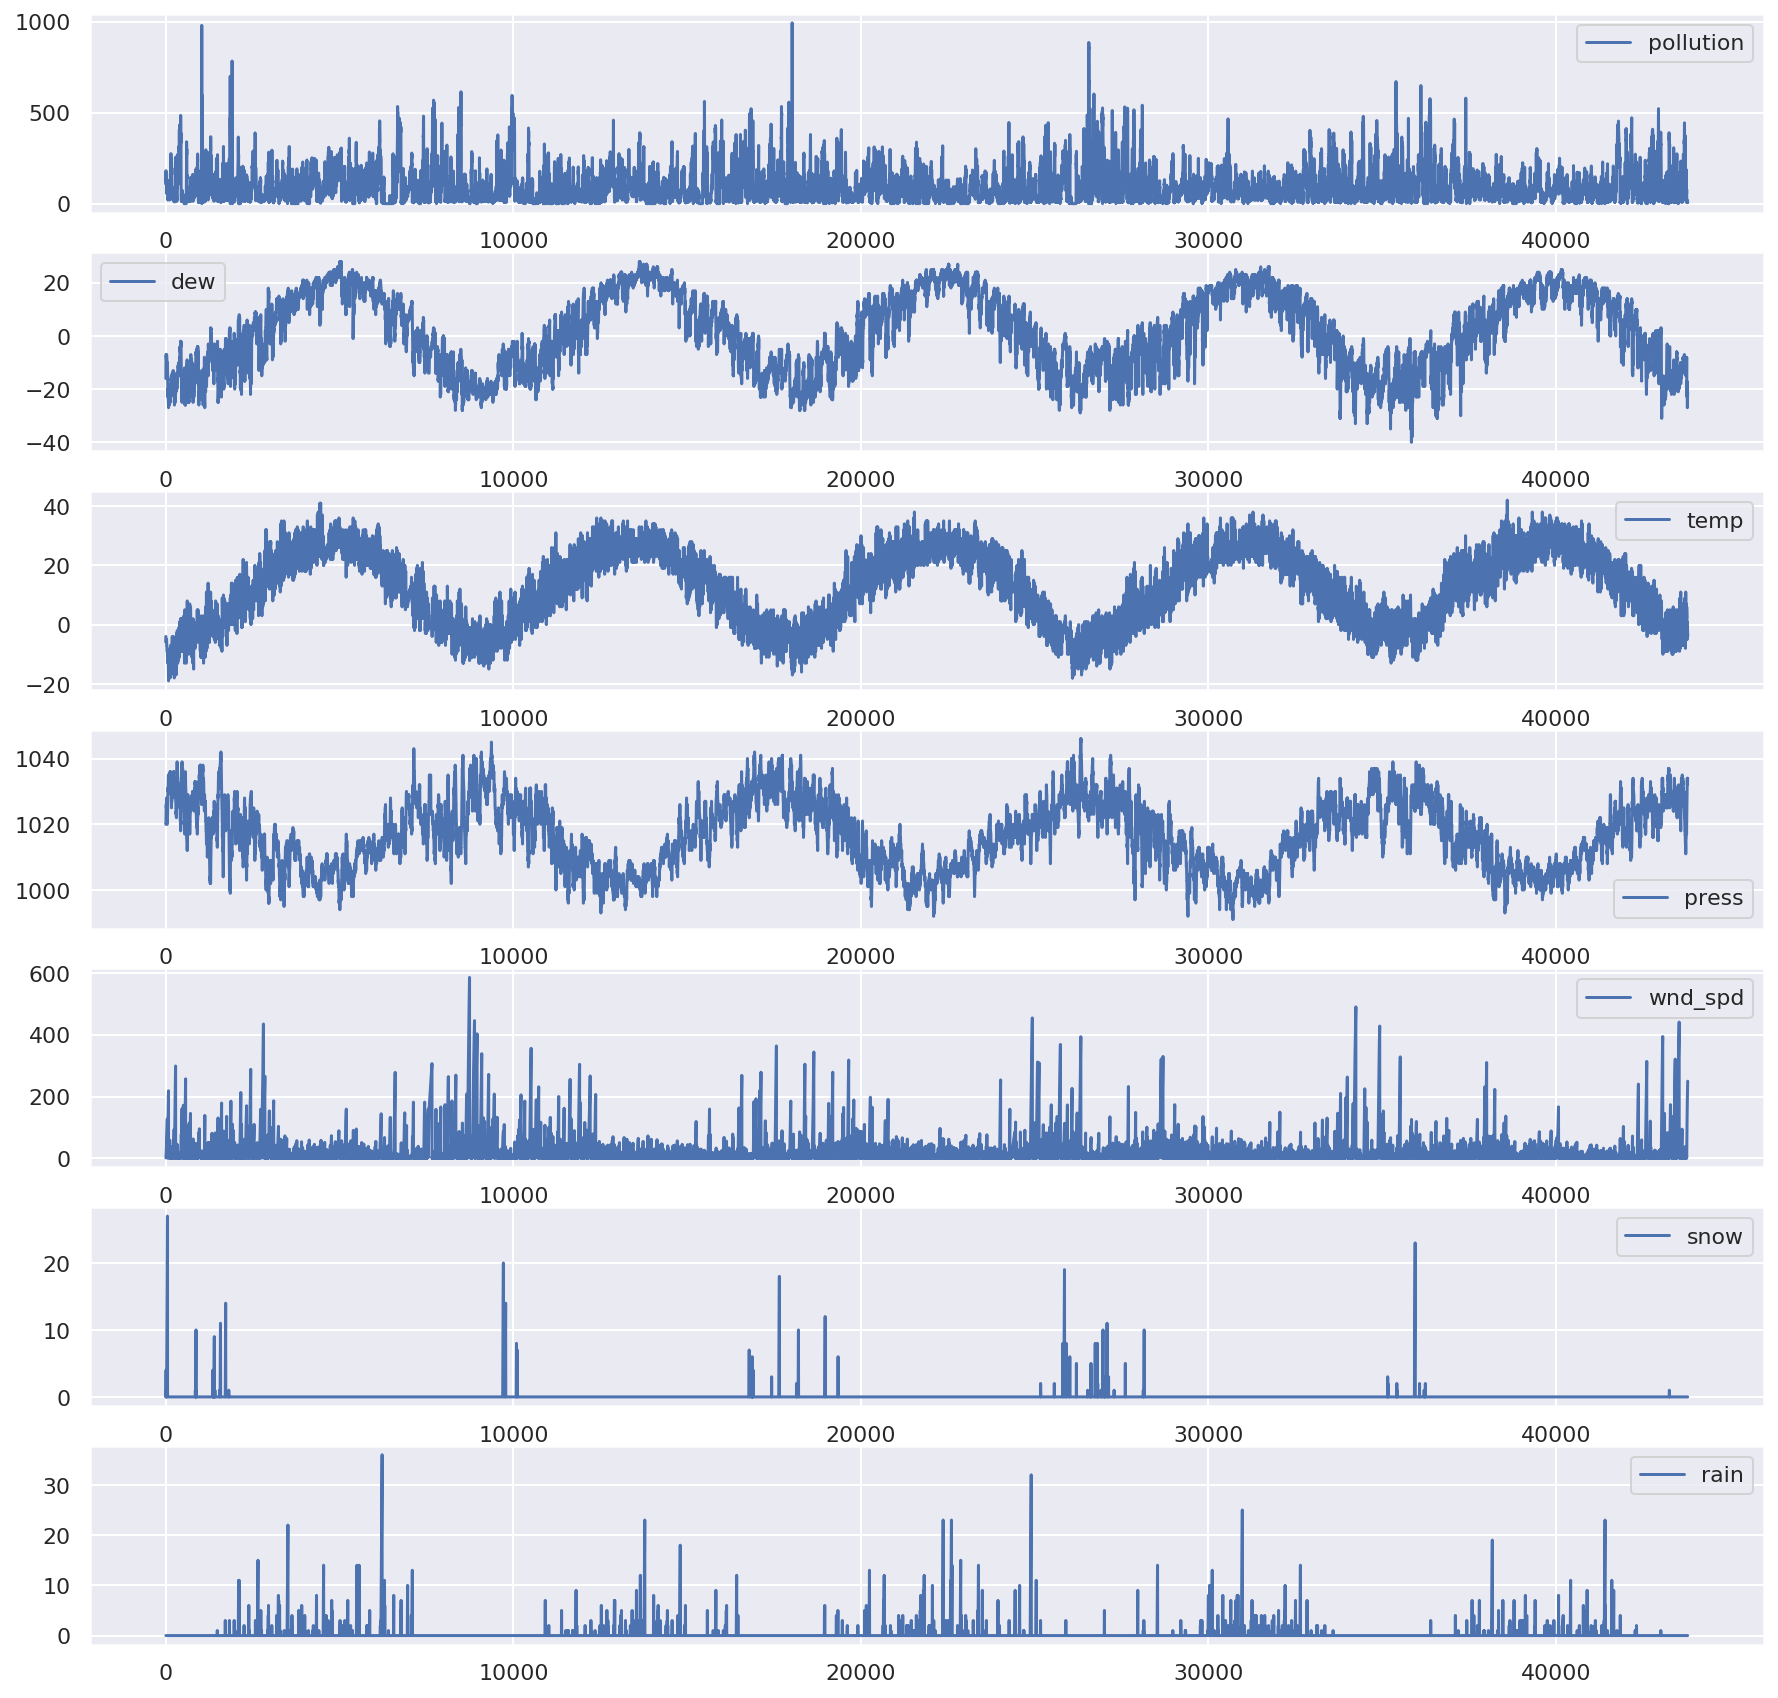

In [7]:
num_feat = 8 #exclude 4th index as it is Categorical feature

fig, ax = plt.subplots(num_feat-1,1)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(num_feat-1):
    if i<4:
        ax[i].plot(corr_ind[corr_ind.columns[i]].values,label=corr_ind.columns[i])
        ax[i].legend()
    elif i>=4:
        ax[i].plot(corr_ind[corr_ind.columns[i+1]].values,label=corr_ind.columns[i+1])
        ax[i].legend()

## 2. Multivariate LSTM Forecast Model

### 2.1. LSTM Data Preparation

In this section, we'll frame the given problem as a supervised learning problem. The same can be defined formally as below:

    * Predict the pollution level at the next hour, given the pollution level and weather conditions at just the _previous_ time step.
 
Some other formulations (as per Jason Brownlee, one can explore more):

     * Predict the pollution for the next hour based on the weather conditions and pollution over the last 24 hours.
     
     * Predict the pollution for the next hour as above and given the “expected” weather conditions for the next hour.

#### 2.1.1. To transform Time Series problem to Supervised learning Problem (Also Feature Scaling).

In [95]:
corr_ind

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [105]:
def ts_to_supervised(cleaned_df, num_past_lags, num_future_lags, cat_feat = 'wnd_dir',dropnan = False):
    '''
    Inputs:-
    cleaned_df: cleaned, final pandas dataframe on which operations will be executed.
    num_past_lags: Amount of time steps to look in the past.
    num_future_lags: Amount of time steps to look into the future.
    dropnan: bool, whether to drop NaN generated due to lags or not
    '''
    features = list(corr_ind.columns)
    cat_feat_i = features.index(cat_feat)
    
    encoder = LabelEncoder()
    
    matrix = cleaned_df.values
    matrix[:,cat_feat_i] = encoder.fit_transform(cleaned_df.values[:,cat_feat_i])
    cleaned_df = pd.DataFrame(matrix,columns = cleaned_df.columns)
    
    
    scaler = MinMaxScaler(feature_range=(0,1))
    val_scl = scaler.fit_transform(cleaned_df.values)
    cleaned_df = pd.DataFrame(val_scl, columns = cleaned_df.columns)
    

    
    df = pd.DataFrame()
    
    for feature in features:
        
        
        for i in range(num_past_lags,0,-1):
            
            df[feature + "(t-{})".format(i)] = cleaned_df[feature].shift(i)
         
    for feature in features:
        
        df[feature] = cleaned_df[feature]
            
    for feature in features:
        
        for i in range(1,num_future_lags+1):
            
            df[feature + "(t+{})".format(i)] = cleaned_df[feature].shift(-i)
            
    if dropnan:
        df.dropna(inplace = True)
            
    
    
    
    return df,scaler

    

In [106]:
corr_ind_sup, scaler = ts_to_supervised(corr_ind,1,1,'wnd_dir',True)
corr_ind_sup

,pollution(t-1),dew(t-1),temp(t-1),press(t-1),wnd_dir(t-1),wnd_spd(t-1),snow(t-1),rain(t-1),pollution,dew,...,snow,rain,pollution(t+1),dew(t+1),temp(t+1),press(t+1),wnd_dir(t+1),wnd_spd(t+1),snow(t+1),rain(t+1)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,...,0.000000,0.0,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,...,0.000000,0.0,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0
3,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,...,0.037037,0.0,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0
4,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,...,0.074074,0.0,0.109658,0.485294,0.213115,0.563636,0.666667,0.011433,0.111111,0.0
5,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,...,0.111111,0.0,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43794,0.009054,0.264706,0.295082,0.763636,0.333333,0.377322,0.000000,0.0,0.010060,0.264706,...,0.000000,0.0,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0
43795,0.010060,0.264706,0.278689,0.763636,0.333333,0.385730,0.000000,0.0,0.008048,0.250000,...,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060,0.264706,...,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060,0.264706,...,0.000000,0.0,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.000000,0.0


In [99]:
scaler.inverse_transform(corr_ind_sup)

array([[129.  , -16.  ,  -4.  , ...,   3.57,   0.  ,   0.  ],
       [148.  , -15.  ,  -4.  , ...,   5.36,   1.  ,   0.  ],
       [159.  , -11.  ,  -5.  , ...,   6.25,   2.  ,   0.  ],
       ...,
       [  8.  , -23.  ,  -2.  , ..., 242.7 ,   0.  ,   0.  ],
       [ 10.  , -22.  ,  -3.  , ..., 246.72,   0.  ,   0.  ],
       [ 10.  , -22.  ,  -3.  , ..., 249.85,   0.  ,   0.  ]])


Some other things one can explore
* One-hot encoding wind direction.
* Making all series stationary with differencing and seasonal adjustment.
* Providing more than 1 hour of input time steps.

#### 2.1.2 Making $\verb|Train|$ & $\verb|Test|$ Datasets

We will fit ony on first year data and predict on next 4 years

*Kind Reminder: Question Statement*

 **Predict the pollution level at the next hour, given the pollution level and weather conditions at just the _previous_ time step.**



In [153]:
train_X_ = corr_ind_sup[corr_ind_sup.columns[:8]].iloc[:365*24].values
train_y_ = pd.DataFrame(corr_ind_sup[corr_ind_sup.columns[8]].iloc[:365*24]).values
test_X_ = corr_ind_sup[corr_ind_sup.columns[:8]].iloc[365*24:]
test_y_ = pd.DataFrame(corr_ind_sup[corr_ind_sup.columns[8]].iloc[365*24:]).values

In [154]:
test_X_

,pollution(t-1),dew(t-1),temp(t-1),press(t-1),wnd_dir(t-1),wnd_spd(t-1),snow(t-1),rain(t-1)
8761,0.036217,0.338235,0.196721,0.836364,0.333333,0.127574,0.0,0.0
8762,0.031187,0.338235,0.196721,0.836364,0.000000,0.006101,0.0,0.0
8763,0.020121,0.338235,0.196721,0.836364,0.000000,0.014509,0.0,0.0
8764,0.019115,0.323529,0.180328,0.836364,0.333333,0.006101,0.0,0.0
8765,0.018109,0.323529,0.180328,0.836364,0.000000,0.006101,0.0,0.0
...,...,...,...,...,...,...,...,...
43794,0.009054,0.264706,0.295082,0.763636,0.333333,0.377322,0.0,0.0
43795,0.010060,0.264706,0.278689,0.763636,0.333333,0.385730,0.0,0.0
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.0,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.0,0.0


In [152]:
test_y_

array([[0.03118712],
       [0.02012072],
       [0.01911469],
       ...,
       [0.01006036],
       [0.01006036],
       [0.00804829]])

Since LSTM requires the data of shape $\verb|[observation, time steps, features]|$, therefore we have to accordingly reshape our data.

In [60]:
train_X = train_X_.reshape(train_X_.shape[0],1,train_X_.shape[1])
test_X = test_X_.reshape(test_X_.shape[0],1,test_X_.shape[1])
train_y = train_y_.reshape(-1,)
test_y = test_y_.reshape(-1,)

In [61]:
(train_X.shape, test_X.shape)

((8760, 1, 8), (35038, 1, 8))

In [62]:
(train_y.shape, test_y.shape)

((8760,), (35038,))

In [63]:
import keras

### 2.2 LSTM Model Development and Fitting.

Neurons: 50

In [84]:
def fit_lstm_model(X_train, y_train, X_test, y_test, loss = 'mae', optimizer = 'adam',epochs = 50, neurons = 50, batch_size=50, plot = True):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(neurons, input_shape = (X_train.shape[1], X_train.shape[2])))  #input_shape (to the LSTM) = [time_steps,features]
    model.add(keras.layers.Dense(1))
    
    model.compile(loss=loss, optimizer=optimizer)
    
    history = model.fit(x = X_train, y = y_train, epochs=epochs, verbose = 2, validation_data=(X_test, y_test), batch_size=batch_size)
        
    if plot:    
        plt.figure(figsize = (15,5))
        plt.plot(history.history['loss'], label = "Training Loss")
        plt.plot(history.history['val_loss'], label = "Validation Loss")
        plt.xlabel("")
        plt.legend()
    return model

Train on 8760 samples, validate on 35038 samples
Epoch 1/50
 - 8s - loss: 0.0477 - val_loss: 0.0271
Epoch 2/50
 - 1s - loss: 0.0169 - val_loss: 0.0138
Epoch 3/50
 - 1s - loss: 0.0146 - val_loss: 0.0135
Epoch 4/50
 - 1s - loss: 0.0143 - val_loss: 0.0133
Epoch 5/50
 - 2s - loss: 0.0143 - val_loss: 0.0141
Epoch 6/50
 - 1s - loss: 0.0144 - val_loss: 0.0133
Epoch 7/50
 - 2s - loss: 0.0146 - val_loss: 0.0132
Epoch 8/50
 - 2s - loss: 0.0143 - val_loss: 0.0135
Epoch 9/50
 - 1s - loss: 0.0142 - val_loss: 0.0135
Epoch 10/50
 - 2s - loss: 0.0143 - val_loss: 0.0133
Epoch 11/50
 - 2s - loss: 0.0142 - val_loss: 0.0136
Epoch 12/50
 - 2s - loss: 0.0143 - val_loss: 0.0161
Epoch 13/50
 - 2s - loss: 0.0142 - val_loss: 0.0133
Epoch 14/50
 - 3s - loss: 0.0143 - val_loss: 0.0131
Epoch 15/50
 - 2s - loss: 0.0142 - val_loss: 0.0138
Epoch 16/50
 - 2s - loss: 0.0143 - val_loss: 0.0132
Epoch 17/50
 - 2s - loss: 0.0145 - val_loss: 0.0132
Epoch 18/50
 - 2s - loss: 0.0143 - val_loss: 0.0131
Epoch 19/50
 - 2s - loss

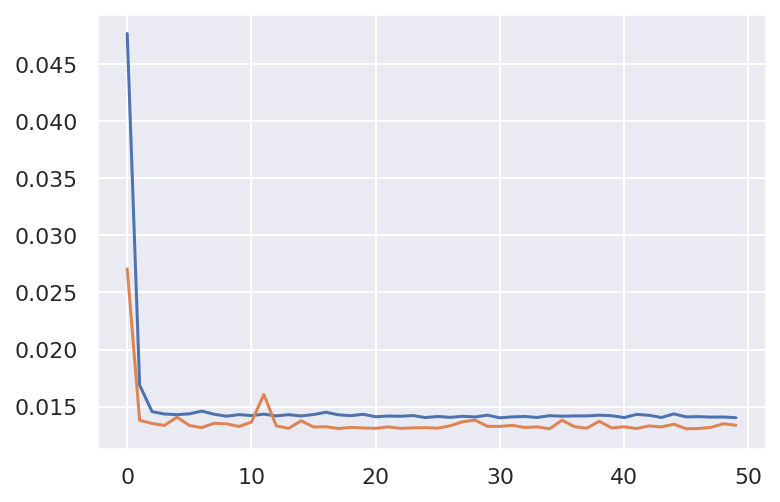

In [81]:
lstm_model = fit_lstm_model(train_X,train_y, test_X, test_y)

### 2.3 Evaluating Model & Getting Predictions in Original form

In [183]:
def lstm_model_predict(model, scaler, X_test, y_test,plot = True, plot_range = 5000):
    y_pred = model.predict(X_test)
    X = np.c_[y_pred.reshape(-1,1),X_test.reshape(X_test.shape[0],X_test.shape[2])[:,1:]]
    X_prime = scaler.inverse_transform(np.c_[y_test.reshape(-1,1),X_test.reshape(X_test.shape[0],X_test.shape[2])[:,1:]])
    
    X_rescaled = scaler.inverse_transform(X)
    y_pred_final = X_rescaled[:,0]
    y_test_rscld = X_prime[:,0]
    rmse = np.sqrt(mean_squared_error(y_pred,y_pred_final))
    print("RMSE: {}".format(rmse))
    if plot:
        fig,(ax1,ax2) = plt.subplots(2,1)
        fig.set_figheight(12)
        fig.set_figwidth(20)
        ax1.plot(y_pred_final[:plot_range],label = 'Predicted Values')
        ax1.legend()
        ax2.plot(y_test_rscld[:plot_range], label = 'Actual Values')
        ax2.legend()
        
    return y_pred_final

RMSE: 127.54387866210969


array([33.45135824, 29.17458455, 18.43031022, ...,  6.34057872,
        8.20822706,  8.21137271])

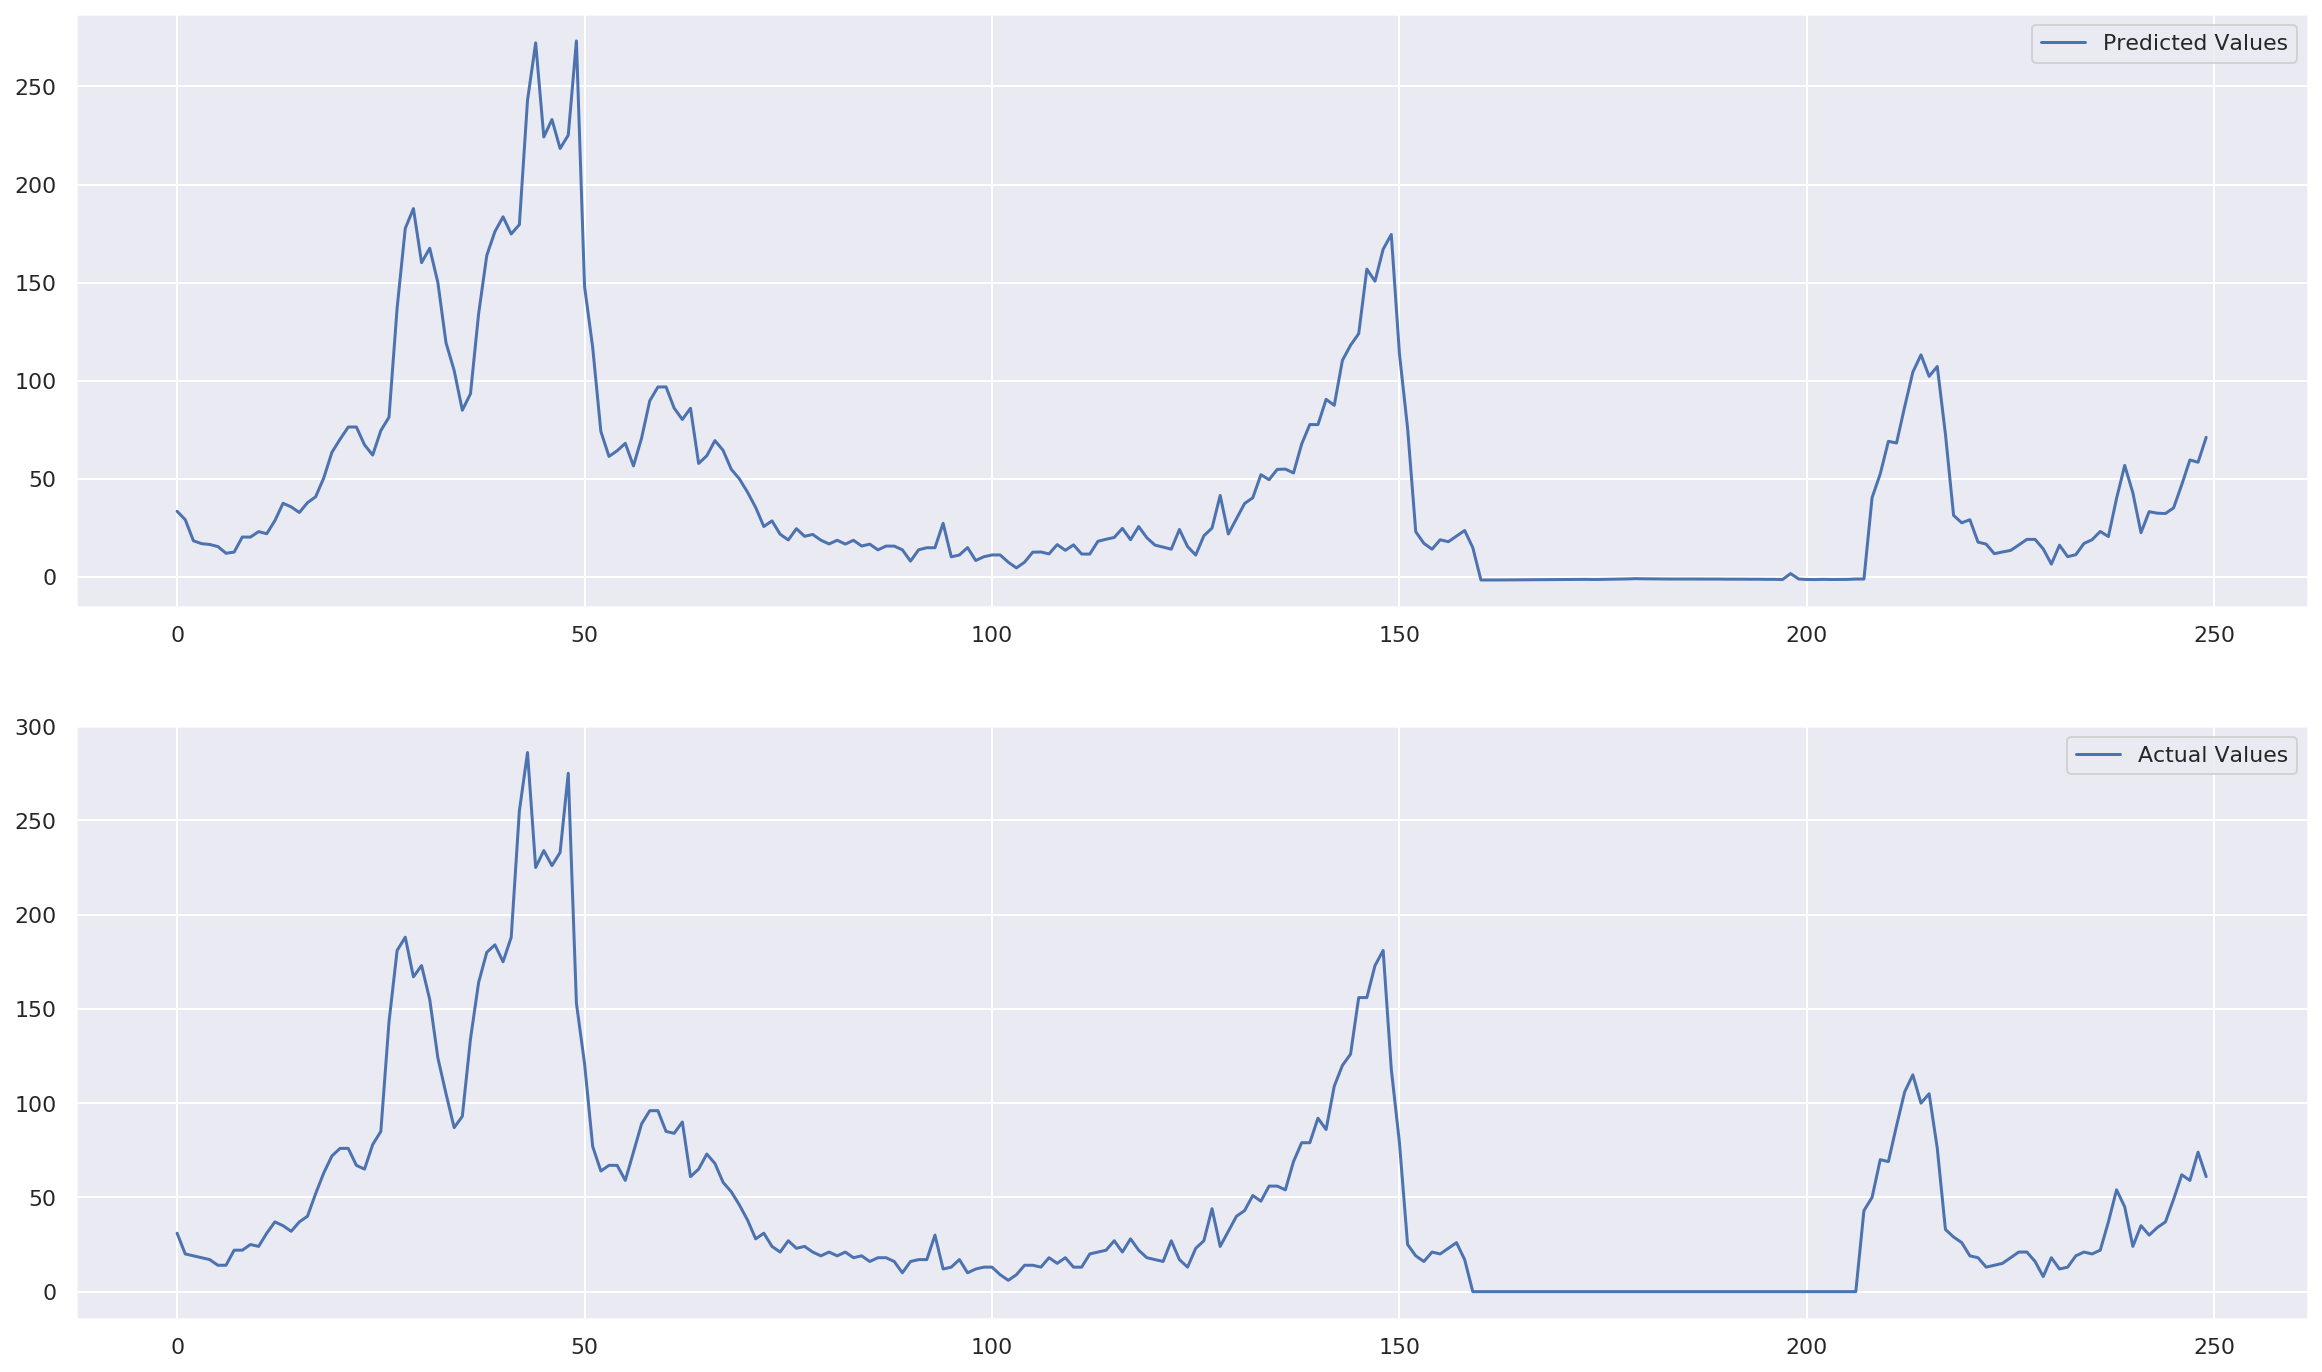

In [186]:
lstm_model_predict(lstm_model, scaler, test_X,test_y,plot_range=250)

This clearly shows, the power of LSTMs in Time-Series Forecasting, which will be now used in $\verb|Labyrinth|$

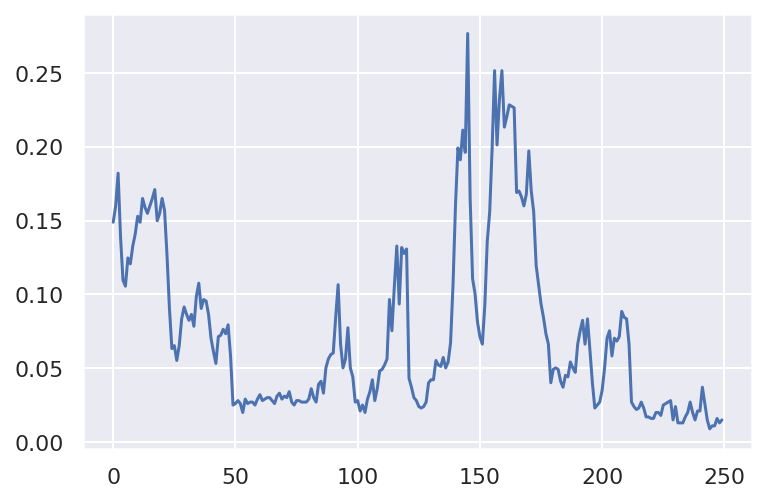

In [190]:
plt.plot(train_y[:250])